In [1]:
# For inline plotting
%matplotlib inline

# For auto reloading
%load_ext autoreload
%autoreload 2

# Experiments of MLP and its sparse variants


- Initial MLP
- MLP with BIBD
- Random sparse MLP

## A bit setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.3.1  Device: cuda


## `Mlp`, `BibdMlp`, `RandomSparseMlp` on MNIST dataset

In [3]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [4]:
from models import Mlp, BibdMlp, RandomSparseMlp


input_dim = 28 * 28 * 1
output_dim = 10

model_list = [
    Mlp(input_dim, output_dim).to(device),
    BibdMlp(input_dim, output_dim).to(device),
    RandomSparseMlp(input_dim, output_dim).to(device)]
for model in model_list:
    print(model)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    print('Cuda is available. Running the model using DataParallel...')

Mlp(
  (fc1): Linear(in_features=784, out_features=49, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=49, out_features=56, bias=True)
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
BibdMlp(
  (fc1): Linear(in_features=784, out_features=49, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (bibd2): BibdLinear()
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
RandomSparseMlp(
  (fc1): Linear(in_features=784, out_features=49, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (randomSparseLinear2): RandomSparseLinear()
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
Cuda is available. Running the model using DataParallel...


In [5]:
def train(model, train_loader, epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [6]:
def validate(model, validation_loader, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [7]:
epochs = 10

loss_ndarray = np.zeros((len(model_list), epochs), dtype=float)
acc_ndarray = np.zeros((len(model_list), epochs), dtype=float)

In [8]:
%%time


import time
import sys
sys.path.append('../util')
from time_utils import format_time


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


for model_index, model in enumerate(model_list):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    criterion = nn.CrossEntropyLoss()
    
    begin_time = time.time() # Begin time
    lossv, accv = [], []
    for epoch in range(1, epochs + 1):
        train(model, train_loader, epoch, log_interval=400)
        validate(model, validation_loader, lossv, accv)
    end_time = time.time() # End time
    print(bcolors.OKBLUE + bcolors.BOLD + 'Time usage for model ' + bcolors.UNDERLINE + bcolors.OKBLUE + model.name + bcolors.ENDC + ': ' + format_time(end_time - begin_time))
    print()
    
    # Store the loss and accuracy data
    for loss_index, loss in enumerate(lossv):
        loss_ndarray[model_index][loss_index] = loss
    for acc_index, acc in enumerate(accv):
        acc_ndarray[model_index][acc_index] = acc

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292201
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.463492
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.417499
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.732150
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.394564

Validation set: Average loss: 0.3441, Accuracy: 9055/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.629761
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.357145
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.738623
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.204432
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.334756

Validation set: Average loss: 0.2525, Accuracy: 9253/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.514225
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.458669
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.265901
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.113637
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.207521

Validation set: Average loss: 0.2097, Accuracy: 9367/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.203810
Train Epoch: 4 [128

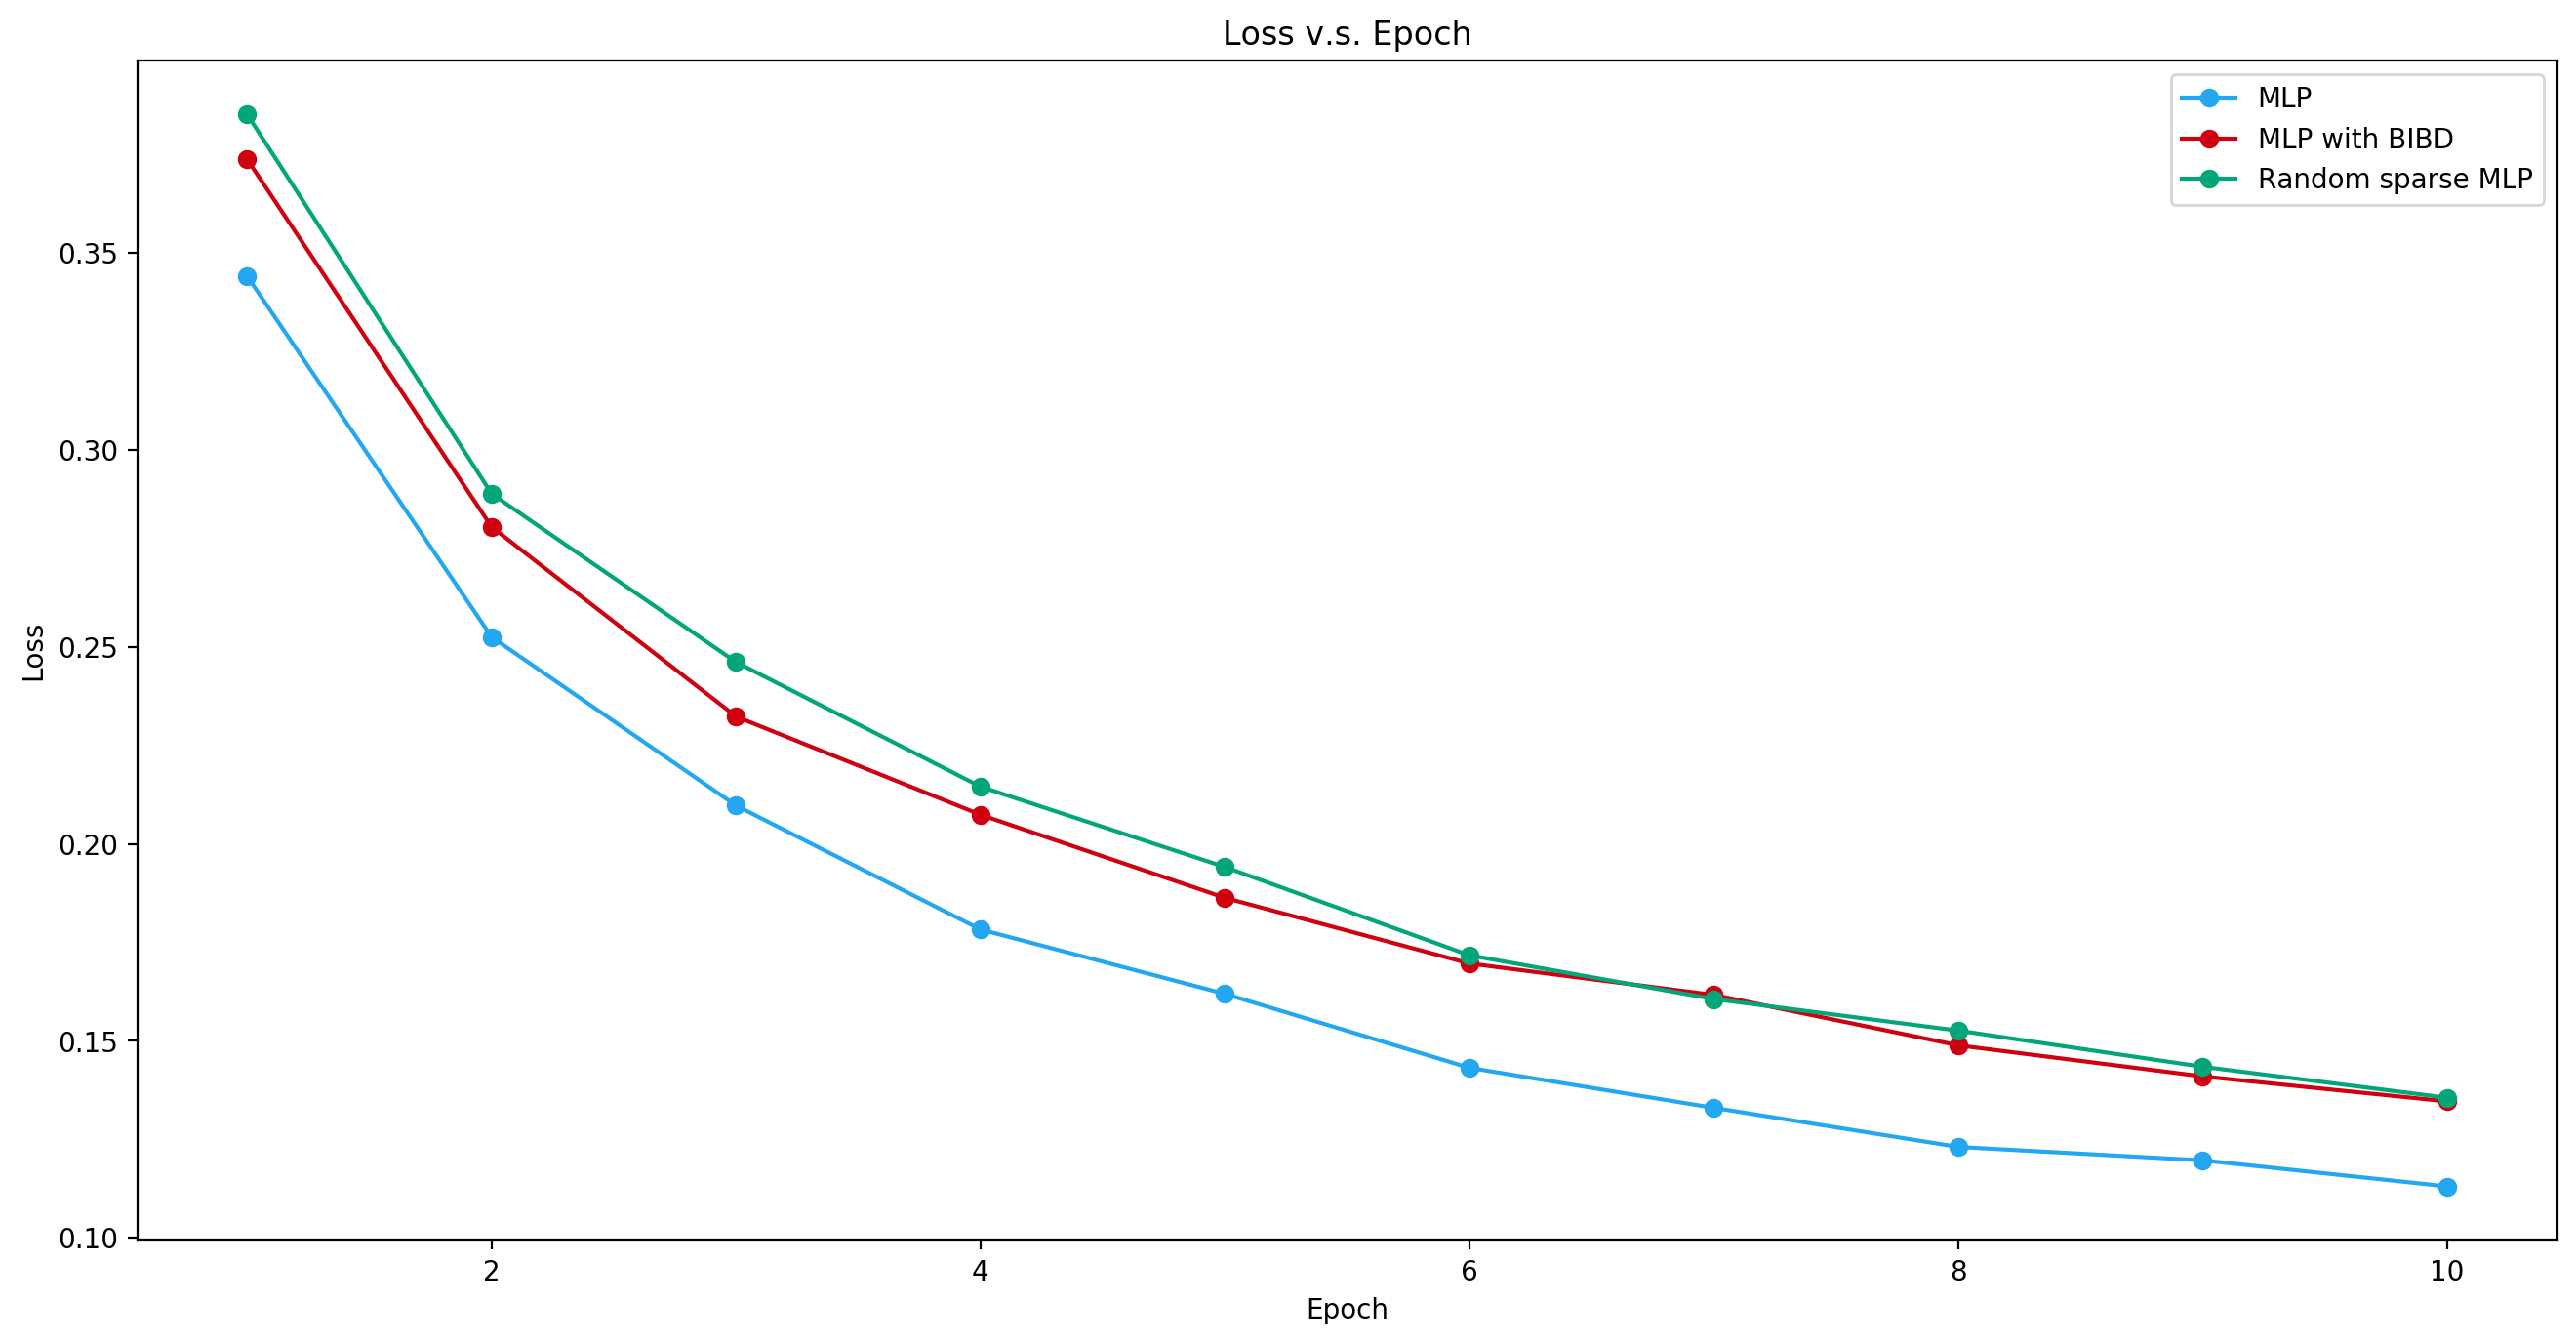

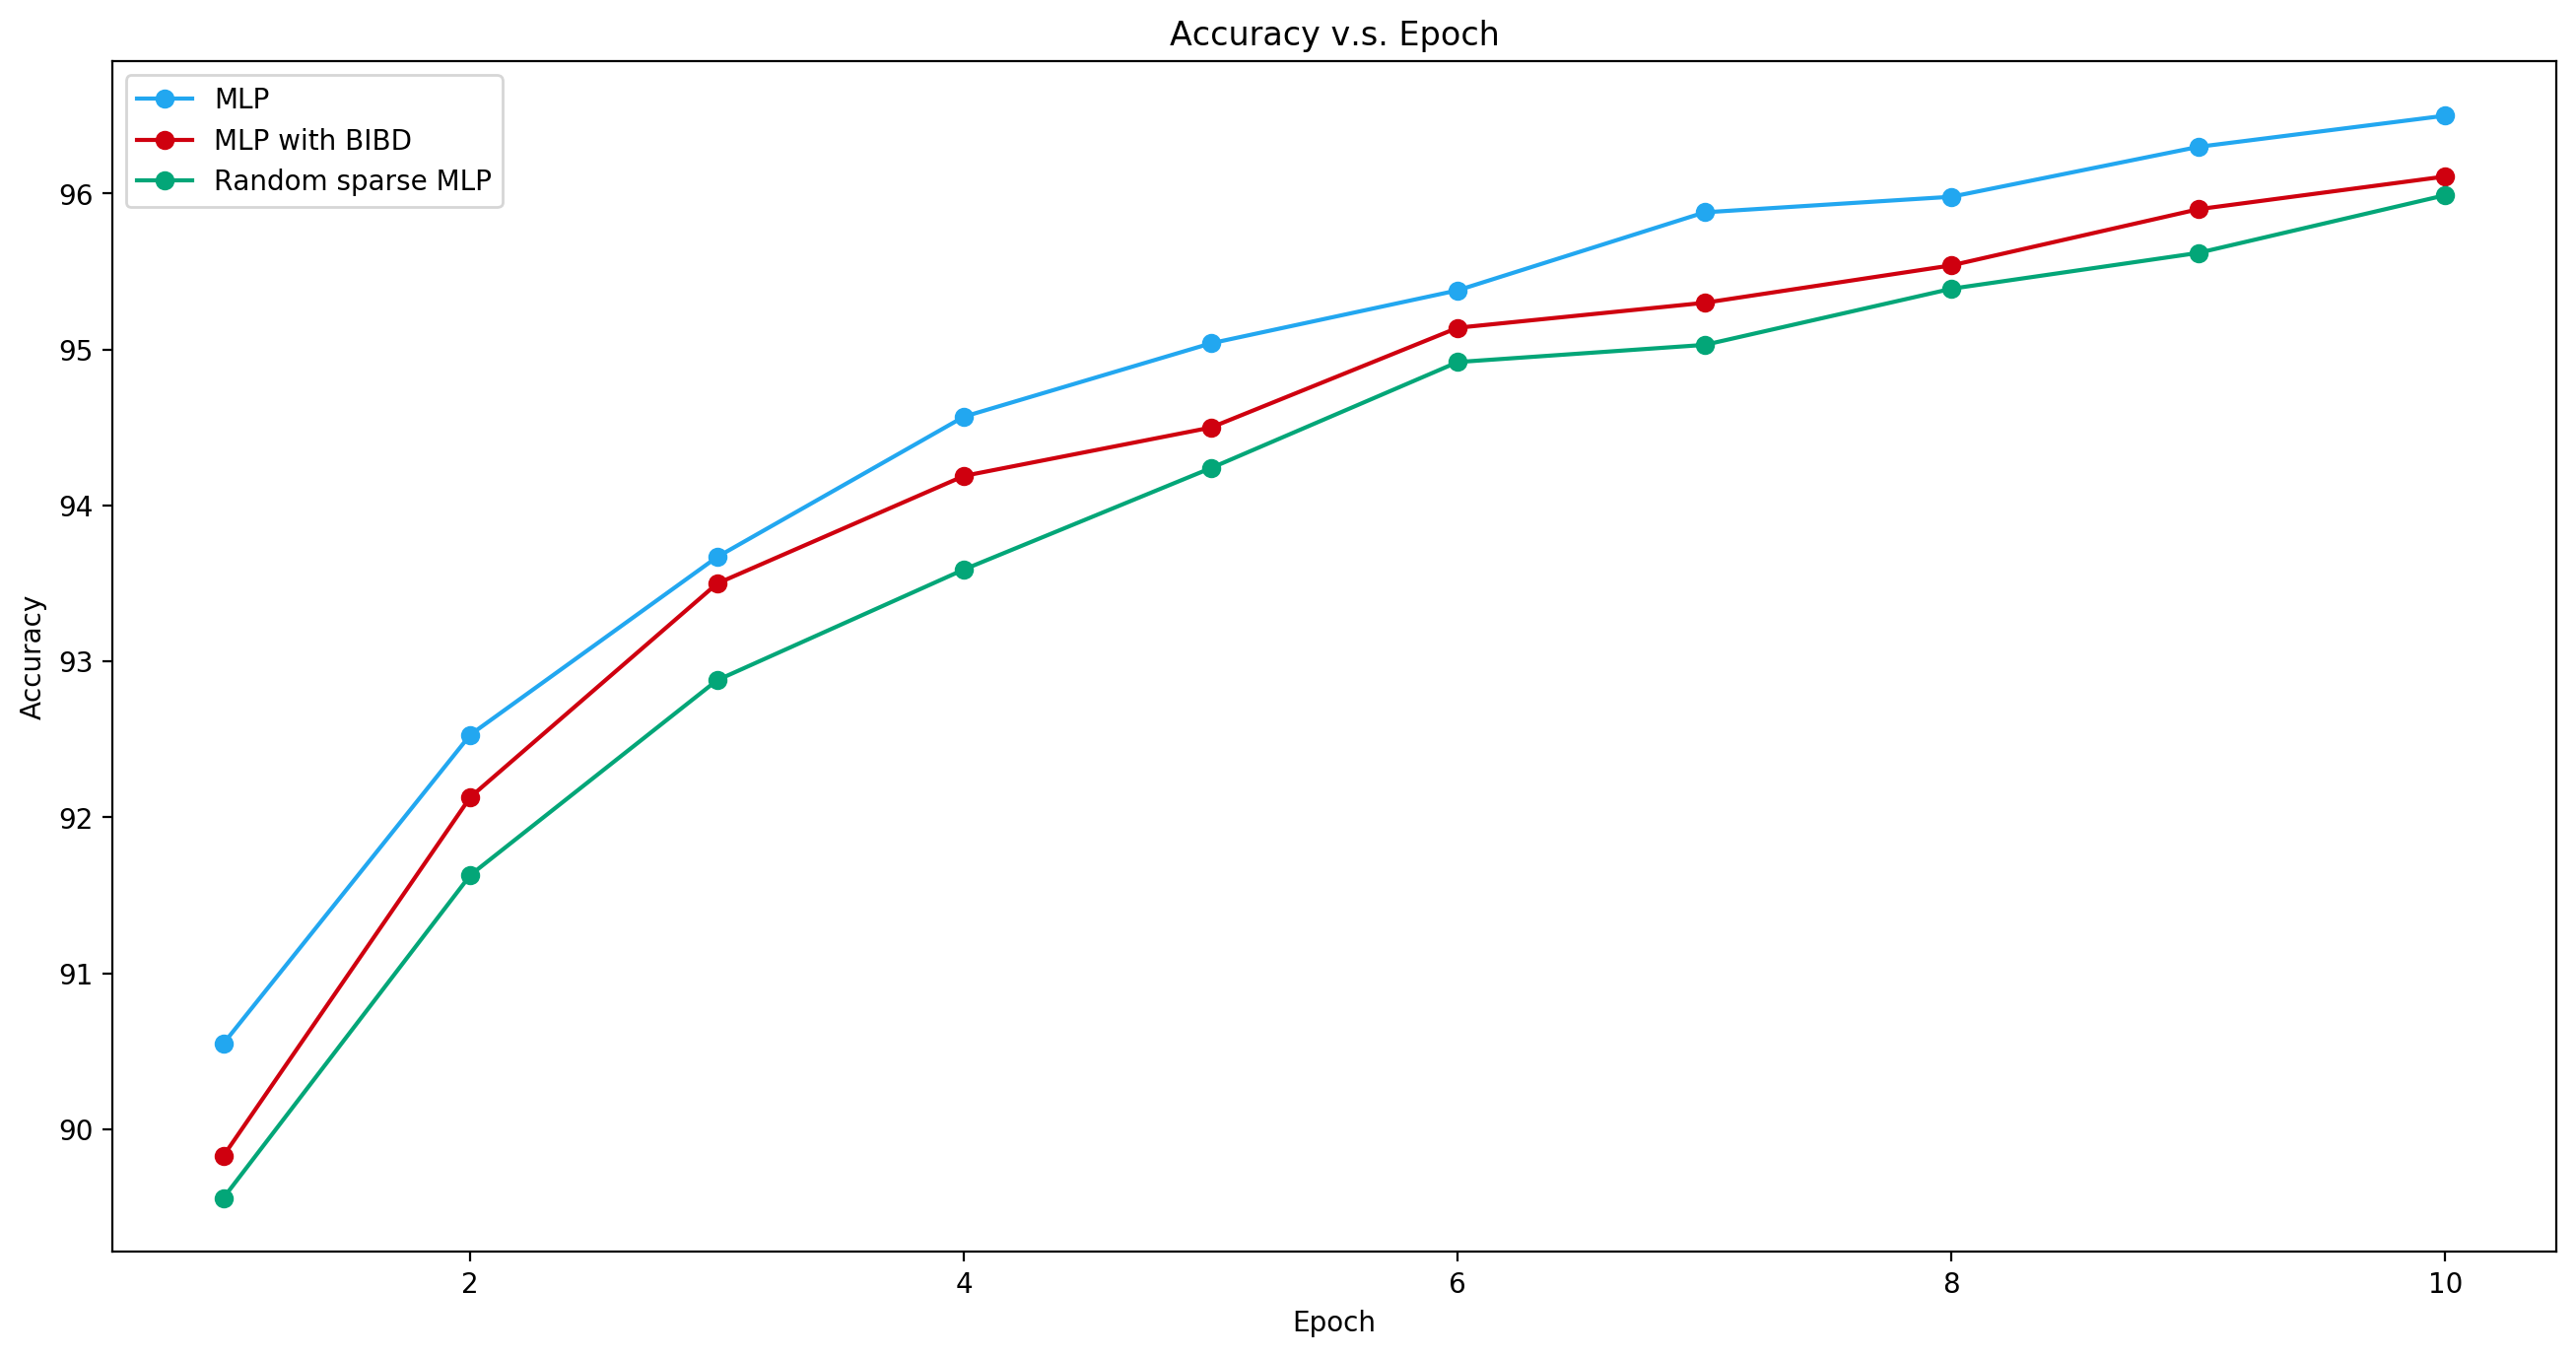

In [28]:
color_list = ['#22a7f0', '#cf000f', '#03a678']

fig, ax = plt.subplots(figsize=(16,8), dpi=200)
for i in range(len(model_list)):
    ax.plot(range(1, epochs + 1), loss_ndarray[i], '-o', color=color_list[i], label=model_list[i].name)
    ax.legend()
    ax.set_title('Loss v.s. Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

fig, ax = plt.subplots(figsize=(16,8), dpi=200)
for i in range(len(model_list)):
    ax.plot(range(1, epochs + 1), acc_ndarray[i], '-o', color=color_list[i], label=model_list[i].name)
    ax.legend()
    ax.set_title('Accuracy v.s. Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')